# Modelo de migración multiescala

### Después de ejecutar todas las celdas, desplácese hacia abajo hasta llegar a "Editing Variable Values"

Este cuaderno implementa nuestro modelo usando `numpy`, `haversine` y `pandas` (con
xlrd). Ha sido probado para funcionar en Python 3.10. Para comenzar, importa las
librerías necesarias.

In [ ]:
# When prompted, allow Google Colab to access your Google Drive. It will
# clone a copy of the GOS GitHub repository into your Google Drive.

from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive
!git clone https://github.com/crcresearch/GOS
%cd GOS
!pip install -r requirements.txt
!pip install shapely==1.8.0
%cd examples/multiscale-migration

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive
fatal: destination path 'GOS' already exists and is not an empty directory.
/content/gdrive/My Drive/GOS
/content/gdrive/My Drive/GOS/examples/multiscale-migration


In [ ]:
import os
import sys
working_directory = os.path.abspath('')
sys.path.append(os.path.normpath(os.path.join(working_directory, "..", "..")))

In [ ]:
# This library should be used to disable warnings during student use.  Turn on warnings when developing.
import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')

In [ ]:
# These libraries are used later to supply mathematical calculations.
import numpy as np
import pandas as pd
from math import e
from haversine import haversine
import ipywidgets as widgets
from ipywidgets import *
# Visualizaton
import matplotlib
import matplotlib.pyplot as plt
import gos
from gos.visualization import map_plot
%matplotlib inline
# Reduce some visual clutter by only printing ten rows at a time.
# This can be adjusted to match personal preferences.
pd.set_option("display.max_rows", 10)

In [ ]:
plt.style.use('ggplot')

Los conjuntos de datos utilizados en el modelo se encuentran en el subdirectorio
`/data`. Muchos están en formato CSV o XLSX.

In [ ]:
print('\n'.join(os.listdir('data')))

A&B values for RTS.xlsx
CIA_Unemployment.csv
Country_List_ISO_3166_Codes_Latitude_Longitude.csv
Freedom_index.xlsx
PassportIndex.xlsx
UN_MigrantStockByOriginAndDestination_2015.xlsx
languages.csv
newPOP.csv
other.csv
wb-codes.csv
wb-original.csv
immigration.xlsx
net_migration.xlsx
emigration.xlsx
baseline_immigration.xlsx
baseline_emigration.xlsx
baseline_net_migration.xlsx


## Utilice esta herramienta para cambiar el nivel en el que se estudia la migración


In [ ]:
skill = IntSlider(min=0, max=100, value=100)

Las siguientes funciones de acceso directo ayudan a localizar estos archivos de
datos fácilmente.

In [ ]:
def file_path(name):
    """
    Shortcut function to get the relative path to the directory
    which contains the data.
    """
    return "./data/%s" % name

## Limpieza de los datos

En este paso, definimos algunas funciones auxiliares que ayudarán a que todos los conjuntos de datos se puedan comunicar entre sí.

In [ ]:
column_names = ["Name", "Code"]

def country_codes():
    """
    Build country rows from their names, ISO codes, and Numeric
    Country Codes.
    """
    cc = (
        pd.read_csv(
            file_path(
                "Country_List_ISO_3166_Codes_Latitude_Longitude.csv"),
            usecols=[0, 2, 3],
            index_col=1,
            keep_default_na=False))
    #other_codes = pd.read_csv(file_path("other.csv"), index_col=1)

    #
    cc.columns = column_names
    #cc.index.rename("Name")
    return cc #pd.concat([cc, other_codes])

def other_codes():
    other_codes = pd.read_csv(file_path("other.csv"), index_col=1)
    other_codes.columns = column_names[0:1]
    return other_codes

In [ ]:
world = gos.World(index=list(set(country_codes().index) | set(other_codes().index)))

In [ ]:
gos.Neighborhood.update(country_codes().groupby("Alpha-3 code")["Name"].apply(list).to_dict())
gos.Neighborhood.update(other_codes().groupby('ISO')["Name"].apply(list).to_dict())
gos.Neighborhood.update(country_codes().groupby("Alpha-3 code")["Code"].apply(list).to_dict())

<font color=red>
    
# Importación de datos

### Índice de Libertad

El [Índice de Libertad](https://freedomhouse.org/report/freedom-world/freedom-world-2017) procede del Freedom House.

Un índice de libertad alto indica un país políticamente libre.
</font>


<Axes: ylabel='Frequency'>

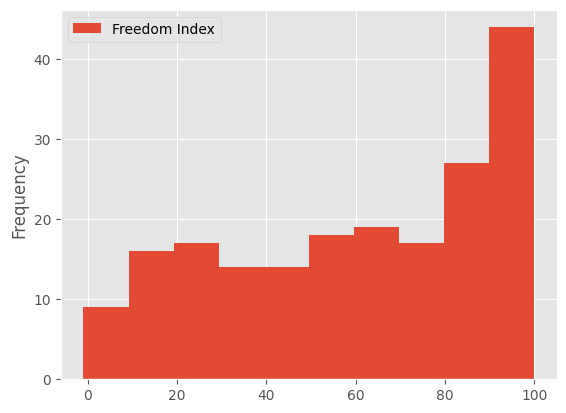

In [ ]:
def freedom_index():
    """
    Read data from the Freedom Index.
    """
    # TODO: Add xlrd to requirements.
    xl = pd.ExcelFile(file_path("Freedom_index.xlsx"))
    xl = xl.parse(1)
    xl.set_index("Country")
    return xl

fi = freedom_index().set_index("Country")
fi.columns = ["Freedom Index"]
fi.plot.hist(bins=10)
#print(len(fi))

<font color=red>

### A/B Values

These values are used in the return to skill function. These values are based on each country's income distribution.
</font>

array([<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>],
      dtype=object)

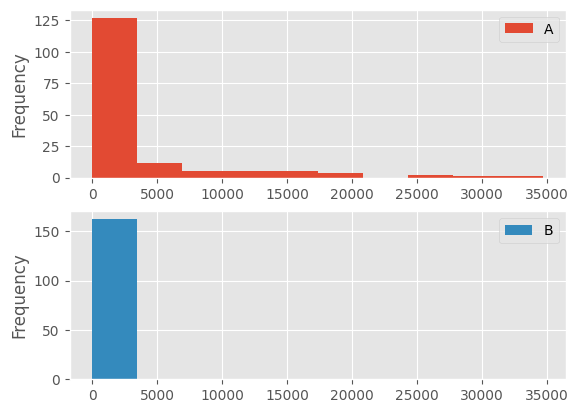

In [ ]:
def ab_values():
    """
    Read generated A/B values for each country.
    """
    return pd.read_excel(file_path("A&B values for RTS.xlsx"))

ab = ab_values()
ab = ab.set_index("Country")
#ab.info()
#print(ab)
ab.plot.hist(subplots=True, sharex=False)

<font color=red>

### Índice de Pasaporte

El [Índice de Pasaporte](https://www.cato.org/human-freedom-index) procede de Arton Capital.

Un índice de pasaporte bajo indica un país acogedor.
</font>


<Axes: ylabel='Frequency'>

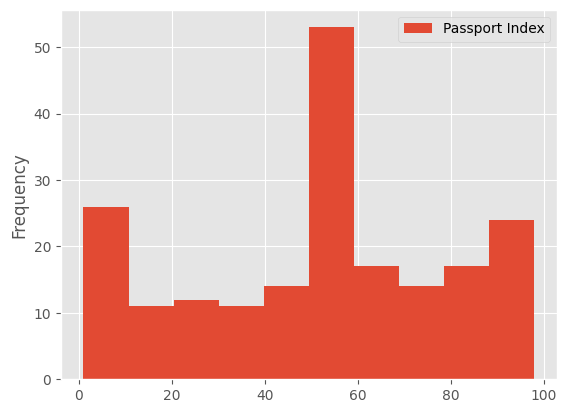

In [ ]:
def passport_index():
    """
    Read data from the Passport Index.
    """
    pi = pd.read_excel(file_path("PassportIndex.xlsx"))
    pi = pi.set_index("Country")
    pi.columns = ["Passport Index"]
    return pi

pi = passport_index()
pi.plot.hist()

<font color=red>

## Desempleo

</font>

<Axes: ylabel='Frequency'>

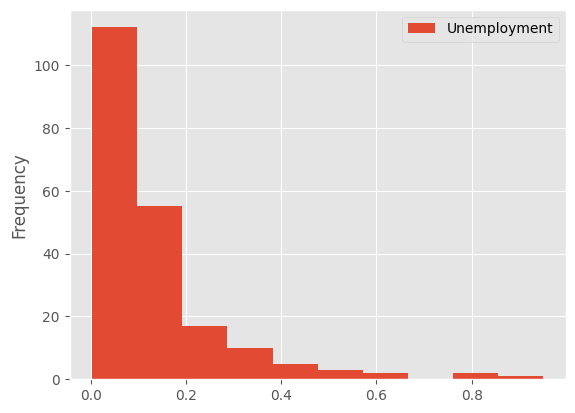

In [ ]:
unemployment_data = pd.read_csv(file_path("CIA_Unemployment.csv"), index_col=0, usecols=[1, 2])
unemployment_data["Unemployment"] /= 100
unemployment_data.plot.hist()

<font color=red>

## Población

</font>

In [ ]:
# Population
population = pd.read_csv(file_path("newPOP.csv"))
population = population.set_index("Country")
population

,Population
Country,
Aruba,101669.00
Afghanistan,28803167.00
Angola,23369131.00
Albania,2913021.00
Andorra,84449.00
...,...
Kosovo,1775680.00
Yemen,23606779.00
South Africa,50979432.36


In [ ]:
world.update_neighborhoods(ab)
world.update_neighborhoods(pi)
world.update_neighborhoods(unemployment_data)
world.update_neighborhoods(population)
world.update_neighborhoods(fi)

Dropped:  []
Not found in other sets:  ['MHL', 'REU', 'DMA', 'HKG', 'SMR', 'BMU', 'GNQ', 'WLF', 'SHN', 'GRL', 'PLW', 'FRO', 'TWN', 'NZL', 'GRD', 'SGS', 'SOM', 'FLK', 'CYM', 'PSE', 'GLP', 'MYT', 'CXR', 'KWT', 'BHS', 'CCK', 'ATA', 'ARE', 'VIR', 'VAT', 'AFG', 'BRB', 'SPM', 'MTQ', 'KNA', 'MNP', 'VGB', 'NFK', 'SAU', 'IMN', 'GUM', 'LIE', 'IOT', 'CUW', 'MSR', 'NIU', 'BVT', 'TCA', 'AND', 'CUB', 'NRU', 'NCL', 'ABW', 'AIA', 'ERI', 'ESH', 'ANT', 'PRI', 'ASM', 'SXM', 'VCT', 'TKL', 'ATF', 'MCO', 'HMD', 'BRN', 'JEY', 'GIB', 'MLT', 'COK', 'LBY', 'GUF', 'QAT', 'SGP', 'PYF', 'MAC', 'ATG', 'BES', 'OMN', 'UMI', 'PRK', 'SJM', 'KHM', 'GGY', 'BHR', 'ZWE', 'PCN']
Dropped:  ['KHM', 'DMA', 'PLW', 'MAC', 'VCT', 'SGP', 'PSE', 'HKG', 'BHS', 'ZWE', 'KNA', 'BRB', 'ATG', 'GRD', 'AND', 'LIE', 'MLT', 'MCO', 'SMR', 'VAT', 'QAT', 'MHL', 'OMN', 'BHR', 'TWN', 'BRN', 'NZL', 'KWT', 'ARE', 'CUB', 'NRU', 'SAU', 'GNQ', 'ERI', 'LBY', 'AFG', 'PRK', 'SOM']
Not found in other sets:  ['WEGZ']
Dropped:  ['KHM', 'QAT', 'GGY', 'JEY', 

,Freedom Index
ALB,68
ARG,82
ARM,45
AUS,98
AUT,95
...,...
VNM,20
VUT,80
YEM,14
ZAF,78


<font color=red>

## Lenguaje compartido

\begin{equation}
    L_{O\leftrightarrow D}\ =
    \begin{cases}
        0 & \text{if origin and destination share a spoken language} \\
        1 & \text{otherwise} \\
    \end{cases}
\end{equation}

</font>

In [ ]:
lang_csv = pd.read_csv(file_path("languages.csv"), index_col=0)
lang_sets = [set([str(y).strip() for y in x[1] if y != ' ']) for x in lang_csv.iterrows()]
overlap = []
for s in lang_sets:
    o = []
    for i in range(len(lang_sets)):
        o.append(len(lang_sets[i].intersection(s)) >= 1)
    overlap.append(o)
lang_data = pd.DataFrame(overlap, index=lang_csv.index, columns=lang_csv.index)
print(len(lang_data))
world.add_matrix("language", 1-lang_data)

218
Could not find:  ['ZAR', 'TMP', 'FRE', 'GAZ', 'ROM']
Could not find:  ['ZAR', 'TMP', 'FRE', 'GAZ', 'ROM']


,ALB,DZA,ARG,ARM,AUS,AUT,AZE,BGD,BLR,BEL,...,UKR,GBR,USA,URY,UZB,VUT,VEN,VNM,YEM,ZMB
ALB,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
DZA,1,0,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,1,0,1
ARG,1,1,0,1,1,1,1,1,1,1,...,1,1,0,0,1,1,0,1,1,1
ARM,1,1,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
AUS,1,1,1,1,0,1,1,0,1,1,...,1,0,0,1,1,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VUT,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,1,1
VEN,1,1,0,1,1,1,1,1,1,1,...,1,1,0,0,1,1,0,1,1,1
VNM,1,1,1,1,0,1,1,0,1,1,...,1,0,0,1,1,1,1,0,1,1
YEM,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,1


<font color=red>

## UN Migration History

</font>

In [ ]:
un_pd = pd.read_excel(
        file_path(
            "UN_MigrantStockByOriginAndDestination_2015.xlsx"
        ),
        skiprows=15
    )
un_pd = un_pd.set_index('Unnamed: 1')
un_pd = un_pd.iloc[0:275,7:250]

# TODO: Should we be using the UN numbers for this?
un_pd = un_pd.sort_index().fillna(1)
world.add_matrix("un", un_pd)

Could not find:  ['Africa', 'Asia', 'Australia and New Zealand', 'Caribbean', 'Central America', 'Central Asia', 'Channel Islands', 'Developed regions', 'Developing regions', 'Eastern Africa', 'Eastern Asia', 'Eastern Europe', 'Europe', 'Latin America and the Caribbean', 'Least developed countries', 'Less developed regions excluding least developed countries', 'Melanesia', 'Middle Africa', 'Northern Africa', 'Northern America', 'Northern Europe', 'Oceania', 'Polynesia', 'South America', 'South-Eastern Asia', 'Southern Africa', 'Southern Asia', 'Southern Europe', 'Sub-Saharan Africa', 'WORLD', 'Western Africa', 'Western Asia', 'Western Europe']
Could not find:  ['Channel Islands']


,ALB,DZA,ARG,ARM,AUS,AUT,AZE,BGD,BLR,BEL,...,UKR,GBR,USA,URY,UZB,VUT,VEN,VNM,YEM,ZMB
ALB,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,2628.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
DZA,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1440.0,1968.0,1.0,1.0,1.0,1.0,1.0,4257.0,1.0
ARG,66.0,104.0,1.0,561.0,275.0,1022.0,1.0,1.0,304.0,537.0,...,4408.0,943.0,5135.0,132749.0,1.0,8.0,1240.0,5.0,1.0,1.0
ARM,1.0,1.0,1.0,1.0,1.0,1.0,87675.0,1.0,328.0,1.0,...,2645.0,1.0,1.0,1.0,1061.0,1.0,1.0,1.0,1.0,1.0
AUS,3334.0,1561.0,15423.0,1371.0,1.0,20434.0,538.0,37092.0,2057.0,7849.0,...,17227.0,1289396.0,110643.0,11140.0,1625.0,1572.0,4895.0,227298.0,675.0,7121.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VUT,1.0,1.0,1.0,1.0,629.0,1.0,1.0,1.0,1.0,1.0,...,1.0,108.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
VEN,19.0,95.0,9944.0,34.0,148.0,828.0,1.0,1.0,1.0,395.0,...,211.0,1803.0,11242.0,4795.0,1.0,1.0,1.0,12.0,1.0,1.0
VNM,1.0,1.0,1.0,1.0,37.0,1.0,1.0,7895.0,1.0,1.0,...,1.0,1119.0,3164.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
YEM,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,15.0,1.0,1.0


<font color=blue>

# Calculaciones

</font>

<font color=blue>

## Distancia

La distancia ortodrómica entre la latitud y la longitud promedio de cada país se utiliza para determinar la distancia entre cada par de países. Una mayor distancia entre países corresponde a un mayor costo de la migración.

</font>

In [ ]:
distance_frame = pd.read_csv(
    file_path("Country_List_ISO_3166_Codes_Latitude_Longitude.csv"),
    usecols=[2,4,5],
    index_col=0,
    keep_default_na=False)
locations = [(x[1][0], x[1][1]) for x in distance_frame.iterrows()]
rows = []
for i in range(len(locations)):
    row = []
    for loc in locations:
        row.append(haversine(loc, locations[i]))
    rows.append(row)
distance = pd.DataFrame(rows, distance_frame.index, distance_frame.index)
world.add_matrix("distance", distance / distance.max().max())

,ALB,DZA,ARG,ARM,AUS,AUT,AZE,BGD,BLR,BEL,...,UKR,GBR,USA,URY,UZB,VUT,VEN,VNM,YEM,ZMB
ALB,0.000000,0.105815,0.597475,0.105397,0.689426,0.044053,0.115292,0.332357,0.073126,0.082197,...,0.064645,0.108879,0.457246,0.565456,0.182473,0.789540,0.454184,0.425656,0.197579,0.315345
DZA,0.105815,0.000000,0.492523,0.202478,0.755319,0.116380,0.213293,0.425091,0.172620,0.126921,...,0.169869,0.145872,0.446199,0.459884,0.282619,0.894200,0.376379,0.519595,0.242037,0.279598
ARG,0.597475,0.492523,0.000000,0.691589,0.649479,0.592982,0.702536,0.862511,0.653588,0.576296,...,0.658957,0.571789,0.434729,0.037466,0.770946,0.612930,0.233571,0.888199,0.646693,0.471675
ARM,0.105397,0.202478,0.691589,0.000000,0.586362,0.132565,0.010958,0.227010,0.096682,0.168266,...,0.071601,0.189984,0.525474,0.656711,0.080298,0.692048,0.558385,0.320622,0.139651,0.315251
AUS,0.689426,0.755319,0.649479,0.586362,0.000000,0.718057,0.577700,0.365302,0.667166,0.749560,...,0.650064,0.764047,0.760862,0.663295,0.518109,0.185352,0.854581,0.279761,0.513529,0.524247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VUT,0.789540,0.894200,0.612930,0.692048,0.185352,0.788136,0.681178,0.472773,0.728063,0.792157,...,0.726893,0.783578,0.580062,0.644838,0.611792,0.000000,0.709326,0.378672,0.674623,0.707919
VEN,0.454184,0.376379,0.233571,0.558385,0.854581,0.427252,0.567306,0.779662,0.477835,0.395708,...,0.495347,0.380127,0.227847,0.233834,0.627211,0.709326,0.000000,0.859593,0.614850,0.543426
VNM,0.425656,0.519595,0.888199,0.320622,0.279761,0.444858,0.310443,0.094504,0.389434,0.472119,...,0.375285,0.484589,0.676896,0.869275,0.244157,0.378672,0.859593,0.000000,0.309503,0.451014
YEM,0.197579,0.242037,0.646693,0.139651,0.513529,0.240108,0.141687,0.224692,0.228628,0.279139,...,0.202439,0.305260,0.653644,0.609393,0.163761,0.674623,0.614850,0.309503,0.000000,0.193773


<font color=blue>

# Edición de los valores de las variables

Elimine el "#" y cambie los valores para simular mejor su escenario

Para restablecer los valores, ejecute todas las celdas anteriores

</font>

In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'

#world.data["Freedom Index"]["AUS"]=50
#world.data["Passport Index"]["AUS"]=80
#world.data["Unemployment"]["AUS"]=.058
#world.data["Population"]["AUS"]=8000000
#world.matrices["un"]["AUS"]["USA"]=77845

<font color=blue>

## Calculate "RTS".
This function measures income potential in a given country based on an agent's skill level (x).

It takes the form:
\begin{equation}
RTS = Ae^{Bx}
\end{equation}
Where A and B are constants unique to each country

</font>

In [ ]:
world.update_neighborhoods(pd.Series(world.data["A"] * e ** (world.data["B"] * skill.value)), "rts")

Dropped:  []
Not found in other sets:  []


ALB      8688.967838
ARG     36429.406271
ARM      7980.858221
AUS    118554.189090
AUT     97262.626518
           ...      
VNM      5195.285635
VUT      7034.142555
YEM      2358.461711
ZAF     20137.067935
ZMB      4260.571938
Name: rts, Length: 134, dtype: float64

<font color=blue>

## Country Beta Values
This function sets the beta value to amplify costs.  It is related to RTS but independent.
    
It takes the form:
    \begin{equation}
    \beta = Ae^{Bz}
    \end{equation}
    Where z is a tuning parameter to help in output validation.
    
It used in the following governing model equation:
\begin{equation}
E(W_D)>W_O + \beta * C    
\end{equation}

</font>

In [ ]:
world.update_neighborhoods(pd.Series(world.data["A"] * e ** (world.data["B"] * 82)), "beta")

Dropped:  []
Not found in other sets:  []


ALB     6375.446682
ARG    22286.393005
ARM     5689.634168
AUS    81529.926400
AUT    69840.551613
           ...     
VNM     3566.381890
VUT     4725.511459
YEM     1610.282435
ZAF     9819.422308
ZMB     2212.677695
Name: beta, Length: 134, dtype: float64

<font color=blue>


## Freedom Index difference
\begin{equation}
\frac{FI_D-FI_O}{100}
\end{equation}

This value weighs the origin and destination FI values against eachother.

</font>

In [ ]:
world.data["Freedom Index"]

ALB    68
ARG    82
ARM    45
AUS    98
AUT    95
       ..
VNM    20
VUT    80
YEM    14
ZAF    78
ZMB    56
Name: Freedom Index, Length: 134, dtype: int64

In [ ]:
rows=[]
for i in range(len(world.data["Freedom Index"])):
    row = []
    for freedom_index in world.data["Freedom Index"]:
        diff=(world.data["Freedom Index"][i] - freedom_index)/100.0
        row.append(diff)
    rows.append(row)
    print(row)
fi_diff = (pd.DataFrame(rows, world.data["Freedom Index"].index, world.data["Freedom Index"].index))
print(fi_diff)

[0.0, -0.14, 0.23, -0.3, -0.27, 0.54, -0.27, 0.05, 0.21, -0.12, 0.13, 0.48, -0.19, 0.0, -0.11, 0.13, -0.04, 0.58, -0.31, -0.28, -0.26, 0.53, 0.44, 0.41, 0.04, 0.13, -0.22, -0.23, -0.26, -0.26, -0.27, 0.42, -0.29, 0.0, 0.33, 0.11, 0.42, -0.26, -0.26, 0.56, -0.32, 0.09, -0.22, 0.36, -0.27, 0.04, -0.15, -0.16, 0.14, 0.22, -0.19, 0.29, -0.08, 0.03, -0.09, -0.28, 0.51, 0.41, -0.29, -0.12, -0.21, -0.07, 0.31, -0.28, 0.46, 0.17, 0.31, -0.24, -0.14, 0.56, 0.06, 0.12, 0.04, -0.23, -0.3, -0.19, 0.27, 0.06, 0.28, 0.03, 0.11, 0.23, -0.01, -0.17, 0.15, 0.38, -0.21, 0.24, -0.09, 0.19, 0.18, 0.21, -0.31, -0.32, 0.16, 0.25, -0.15, -0.04, 0.05, 0.04, -0.21, -0.29, 0.04, 0.48, 0.62, -0.1, 0.02, -0.02, -0.08, -0.13, -0.09, -0.21, -0.24, -0.32, 0.5, -0.03, 0.69, 0.36, 0.57, 0.64, -0.06, -0.13, -0.1, 0.3, 0.07, -0.3, -0.32, 0.65, 0.38, 0.48, -0.12, 0.54, -0.1, 0.12]
[0.14, 0.0, 0.37, -0.16, -0.13, 0.68, -0.13, 0.19, 0.35, 0.02, 0.27, 0.62, -0.05, 0.14, 0.03, 0.27, 0.1, 0.72, -0.17, -0.14, -0.12, 0.67, 0.58

<font color=blue>


## Political Barriers
$$  PB = \delta_1 \frac{PI_{D}}{100} +  \delta_2 (1-\frac{(FI_D-FI_O)}{100}) $$

Political barriers combines passport index rank (PI) and freedom index scores (FI) for each country. The greater the value, the higher the cost of migration.

<font color=blue>


In [ ]:
# default delta values, do not edit this cell
delta1=.1
delta2=.9

### Edición de los deltas

Elimine el "#" y cambie los valores para simular mejor su escenario

Para restablecer los valores, ejecute todas las celdas anteriores

In [ ]:
#delta1=.1
#delta2=.9

In [ ]:
political_barriers=delta1*world.data["Passport Index"]/100.0 + delta2*(1 - fi_diff)
print(political_barriers)

       ALB    ARG    ARM    AUS    AUT    AZE    BEL    BFA    BGD    BGR  \
ALB  0.957  1.081  0.720  1.250  1.193  0.496  1.193  0.920  0.726  1.058   
ARG  0.831  0.955  0.594  1.124  1.067  0.370  1.067  0.794  0.600  0.932   
ARM  1.164  1.288  0.927  1.457  1.400  0.703  1.400  1.127  0.933  1.265   
AUS  0.687  0.811  0.450  0.980  0.923  0.226  0.923  0.650  0.456  0.788   
AUT  0.714  0.838  0.477  1.007  0.950  0.253  0.950  0.677  0.483  0.815   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
VNM  1.389  1.513  1.152  1.682  1.625  0.928  1.625  1.352  1.158  1.490   
VUT  0.849  0.973  0.612  1.142  1.085  0.388  1.085  0.812  0.618  0.950   
YEM  1.443  1.567  1.206  1.736  1.679  0.982  1.679  1.406  1.212  1.544   
ZAF  0.867  0.991  0.630  1.160  1.103  0.406  1.103  0.830  0.636  0.968   
ZMB  1.065  1.189  0.828  1.358  1.301  0.604  1.301  1.028  0.834  1.166   

     ...    UKR    URY    USA    UZB    VEN    VNM    VUT    YEM    ZAF    

In [ ]:
world.add_matrix("Political Barriers", political_barriers)

,ALB,ARG,ARM,AUS,AUT,AZE,BEL,BFA,BGD,BGR,...,UKR,URY,USA,UZB,VEN,VNM,VUT,YEM,ZAF,ZMB
ALB,0.957,1.081,0.720,1.250,1.193,0.496,1.193,0.920,0.726,1.058,...,0.883,1.228,1.265,0.405,0.621,0.549,1.040,0.503,1.050,0.818
ARG,0.831,0.955,0.594,1.124,1.067,0.370,1.067,0.794,0.600,0.932,...,0.757,1.102,1.139,0.279,0.495,0.423,0.914,0.377,0.924,0.692
ARM,1.164,1.288,0.927,1.457,1.400,0.703,1.400,1.127,0.933,1.265,...,1.090,1.435,1.472,0.612,0.828,0.756,1.247,0.710,1.257,1.025
AUS,0.687,0.811,0.450,0.980,0.923,0.226,0.923,0.650,0.456,0.788,...,0.613,0.958,0.995,0.135,0.351,0.279,0.770,0.233,0.780,0.548
AUT,0.714,0.838,0.477,1.007,0.950,0.253,0.950,0.677,0.483,0.815,...,0.640,0.985,1.022,0.162,0.378,0.306,0.797,0.260,0.807,0.575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VNM,1.389,1.513,1.152,1.682,1.625,0.928,1.625,1.352,1.158,1.490,...,1.315,1.660,1.697,0.837,1.053,0.981,1.472,0.935,1.482,1.250
VUT,0.849,0.973,0.612,1.142,1.085,0.388,1.085,0.812,0.618,0.950,...,0.775,1.120,1.157,0.297,0.513,0.441,0.932,0.395,0.942,0.710
YEM,1.443,1.567,1.206,1.736,1.679,0.982,1.679,1.406,1.212,1.544,...,1.369,1.714,1.751,0.891,1.107,1.035,1.526,0.989,1.536,1.304
ZAF,0.867,0.991,0.630,1.160,1.103,0.406,1.103,0.830,0.636,0.968,...,0.793,1.138,1.175,0.315,0.531,0.459,0.950,0.413,0.960,0.728


<font color=blue>


## Migration History
Out Migration:  
\begin{equation} OM_{O\rightarrow D}\ = \frac {\text {migrants from origin in destination}} {\text {population of origin}} \end{equation}

Ethnic Enclave:
\begin{equation} EE_{O\leftrightarrow D}\ = \frac {\text{migrants from origin in destination}} {\text {population of destination.}} \end{equation}

Migration History:
\begin{equation}
MH_{O\rightarrow D}\ = \gamma_1 (1-OM_{O\rightarrow D})\ + \gamma_2 (1-EE_{O\rightarrow D})
\end{equation}

</font>

In [ ]:
# default gamma values, do not edit this cell
gamma1=.5
gamma2=.5

### Edición de los gammas

Elimine el "#" y cambie los valores para simular mejor su escenario

Para restablecer los valores, ejecute todas las celdas anteriores

In [ ]:
#gamma1=.5
#gamma2=.5

In [ ]:
OM=world.matrices['un'].sort_index(axis=1).sort_index(axis=0)/world.data['Population']
#transpose UN matrix for this calculation so that we are dividing by population of destination
EE=world.matrices['un'].T.sort_index(axis=1).sort_index(axis=0)/world.data['Population']
EE=EE.T
MH=gamma1*(OM)+gamma2*(EE)
#print(MH)
max_MH = MH.max().nlargest(10).mean()
#print(max_MH)
MH = 1 - (MH/max_MH)
MH[MH<0] = 0
print(MH)

          ALB       ARG       ARM       AUS       AUT       AZE       BEL  \
ALB  0.999997  0.999998  0.999997  0.999998  0.999998  0.999998  0.999998   
ARG  0.999887  1.000000  0.999026  0.999911  0.999314  0.999999  0.999709   
ARM  0.999997  0.999998  0.999997  0.999998  0.999998  0.812485  0.999998   
AUS  0.993949  0.994984  0.997484  1.000000  0.984259  0.999608  0.994972   
AUT  0.993198  0.998977  0.993345  0.998082  0.999999  0.998844  0.997459   
..        ...       ...       ...       ...       ...       ...       ...   
VNM  0.999998  1.000000  0.999998  0.999990  0.999999  0.999999  1.000000   
VUT  0.999979  0.999980  0.999979  0.987436  0.999980  0.999980  0.999980   
YEM  0.999998  1.000000  0.999998  1.000000  0.999999  0.999999  0.999999   
ZAF  0.999722  0.999504  0.999998  0.997769  0.996425  0.999999  0.995558   
ZMB  0.999998  1.000000  0.999998  0.999742  0.999999  0.999999  0.999999   

          BFA       BGD       BGR  ...       UKR       URY       USA  \
ALB

In [ ]:
world.add_matrix("Migration History", MH)

,ALB,ARG,ARM,AUS,AUT,AZE,BEL,BFA,BGD,BGR,...,UKR,URY,USA,UZB,VEN,VNM,VUT,YEM,ZAF,ZMB
ALB,0.999997,0.999998,0.999997,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998,0.999998,...,0.999998,0.999997,0.995747,0.999998,0.999998,0.999998,0.999979,0.999998,0.999998,0.999998
ARG,0.999887,1.000000,0.999026,0.999911,0.999314,0.999999,0.999709,0.999995,1.000000,0.999780,...,0.999052,0.801250,0.999341,1.000000,0.999660,0.999999,0.999841,1.000000,0.999974,1.000000
ARM,0.999997,0.999998,0.999997,0.999998,0.999998,0.812485,0.999998,0.999998,0.999998,0.999998,...,0.995438,0.999997,0.999998,0.998105,0.999998,0.999998,0.999979,0.999998,0.999998,0.999998
AUS,0.993949,0.994984,0.997484,1.000000,0.984259,0.999608,0.994972,0.999989,0.991000,0.996637,...,0.994595,0.982222,0.974878,0.999390,0.998175,0.939612,0.968600,0.999723,0.944336,0.996090
AUT,0.993198,0.998977,0.993345,0.998082,0.999999,0.998844,0.997459,0.999896,0.998388,0.981281,...,0.994565,0.999452,0.993661,0.999456,0.999342,0.997953,0.999858,0.999928,0.998185,0.999899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VNM,0.999998,1.000000,0.999998,0.999990,0.999999,0.999999,1.000000,1.000000,0.999334,0.999999,...,1.000000,0.999999,0.999782,1.000000,1.000000,1.000000,0.999980,1.000000,1.000000,1.000000
VUT,0.999979,0.999980,0.999979,0.987436,0.999980,0.999980,0.999980,0.999980,0.999980,0.999980,...,0.999980,0.999979,0.999980,0.999980,0.999980,0.999980,0.999960,0.999980,0.999980,0.999980
YEM,0.999998,1.000000,0.999998,1.000000,0.999999,0.999999,0.999999,1.000000,1.000000,0.999999,...,1.000000,0.999998,1.000000,1.000000,1.000000,0.999996,0.999980,1.000000,1.000000,0.999999
ZAF,0.999722,0.999504,0.999998,0.997769,0.996425,0.999999,0.995558,1.000000,0.999644,0.996946,...,0.999209,0.999827,0.998067,1.000000,0.999923,0.999976,0.999980,0.999976,1.000000,0.974072


<font color=blue>

# Costo

</font>


<font color=blue>


El costo de la migración entre un origen y un destino es la media ponderada de la distancia, el historial migratorio, el idioma compartido y las barreras políticas entre los dos países.

\begin{equation}
C = { \alpha_1 \frac{D_{O\leftrightarrow D}} {D_{Max}} + \alpha_2 MH_{O\rightarrow D}  + \alpha_3 L_{O\leftrightarrow D} + \alpha_4 PB}
\end{equation}

</font>

In [ ]:
# default alpha values, do not edit this cell
alpha1=.3
alpha2=.5
alpha3=.1
alpha4=.1

### Edición de los alphas

Elimine el "#" y cambie los valores para simular mejor su escenario

Para restablecer los valores, ejecute todas las celdas anteriores

In [ ]:
#alpha1=.3
#alpha2=.5
#alpha3=.1
#alpha4=.1

In [ ]:
# Cost

c = (alpha1*world.matrices["distance"] +
     alpha2*world.matrices["Migration History"] +
     alpha3*world.matrices["language"] +
     alpha4*world.matrices["Political Barriers"])
world.add_matrix("cost", c * world.data['beta'])

,ALB,ARG,ARM,AUS,AUT,AZE,BEL,BFA,BGD,BGR,...,UKR,URY,USA,UZB,VEN,VNM,VUT,YEM,ZAF,ZMB
ALB,3797.843368,19775.641965,4003.326515,75971.788822,51159.239692,4147.180892,46845.055306,765.902206,1615.101561,8838.160351,...,2152.597003,23981.744257,87179.110718,2372.408916,17992.926509,2791.036130,4446.003032,1142.612753,8069.887674,1717.928245
ARG,5497.456780,13271.544510,4929.439529,73963.878154,61756.597211,5138.679178,55376.213330,823.528953,1921.361705,10902.959078,...,2655.149985,14029.057286,75283.495861,2931.839032,13959.771728,3240.982987,4135.765592,1339.284589,7989.577887,1793.822555
ARM,4768.946076,20866.208144,3372.236937,75138.614432,54459.464619,3514.623921,49774.343217,813.033613,1592.297773,9322.520346,...,2214.971599,25273.668656,91559.993220,2335.216783,19163.984451,2752.483068,4405.611502,1147.961175,8299.491221,1763.668584
AUS,5562.591440,19465.732455,4663.513396,48754.878706,62845.777979,4823.203062,57593.333613,911.799120,1360.769627,10890.197349,...,2596.455029,23806.116058,82489.021041,2622.829953,20071.055570,2074.329809,3387.744879,1251.544560,6906.768216,1792.532323
AUT,4343.048892,19192.663515,3892.517447,74612.757975,41555.089213,4042.509271,44420.740289,745.576163,1576.377755,8525.506506,...,2074.945372,23310.119737,83299.619919,2307.839311,17255.777004,2721.270825,4328.897532,1123.971515,7934.290881,1691.105778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VNM,5524.936464,22682.192916,4616.488639,61320.569389,62574.141934,4763.911598,56931.002162,928.070626,1346.397727,10788.195979,...,2567.464466,27591.933435,88303.590114,2582.971983,21707.638707,2133.052817,4067.681296,1266.246815,7853.450480,1903.575744
VUT,5876.575501,19638.081656,4943.174837,62250.019825,65994.473869,5110.693358,59575.722469,985.000916,1680.591279,11466.591591,...,2724.029004,24331.228557,90028.722519,2775.021552,19474.399790,2702.218149,2803.080008,1355.659836,8821.913905,1954.603196
YEM,5123.136084,21187.849419,4338.313643,75631.939087,58661.317521,4489.770792,53625.601228,840.339771,1649.191279,10060.905217,...,2426.165216,25641.957198,98274.051227,2519.095858,20174.569651,2840.084644,4512.755020,964.397832,8213.890919,1744.766213
ZAF,5121.976808,18277.418637,4452.205652,62622.718769,58438.365202,4618.839450,53166.947345,782.227737,1466.367959,10108.438241,...,2462.111196,22177.904427,84445.965055,2605.263267,18244.338836,2487.464281,4249.249638,1166.138041,5852.374796,1515.532030


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

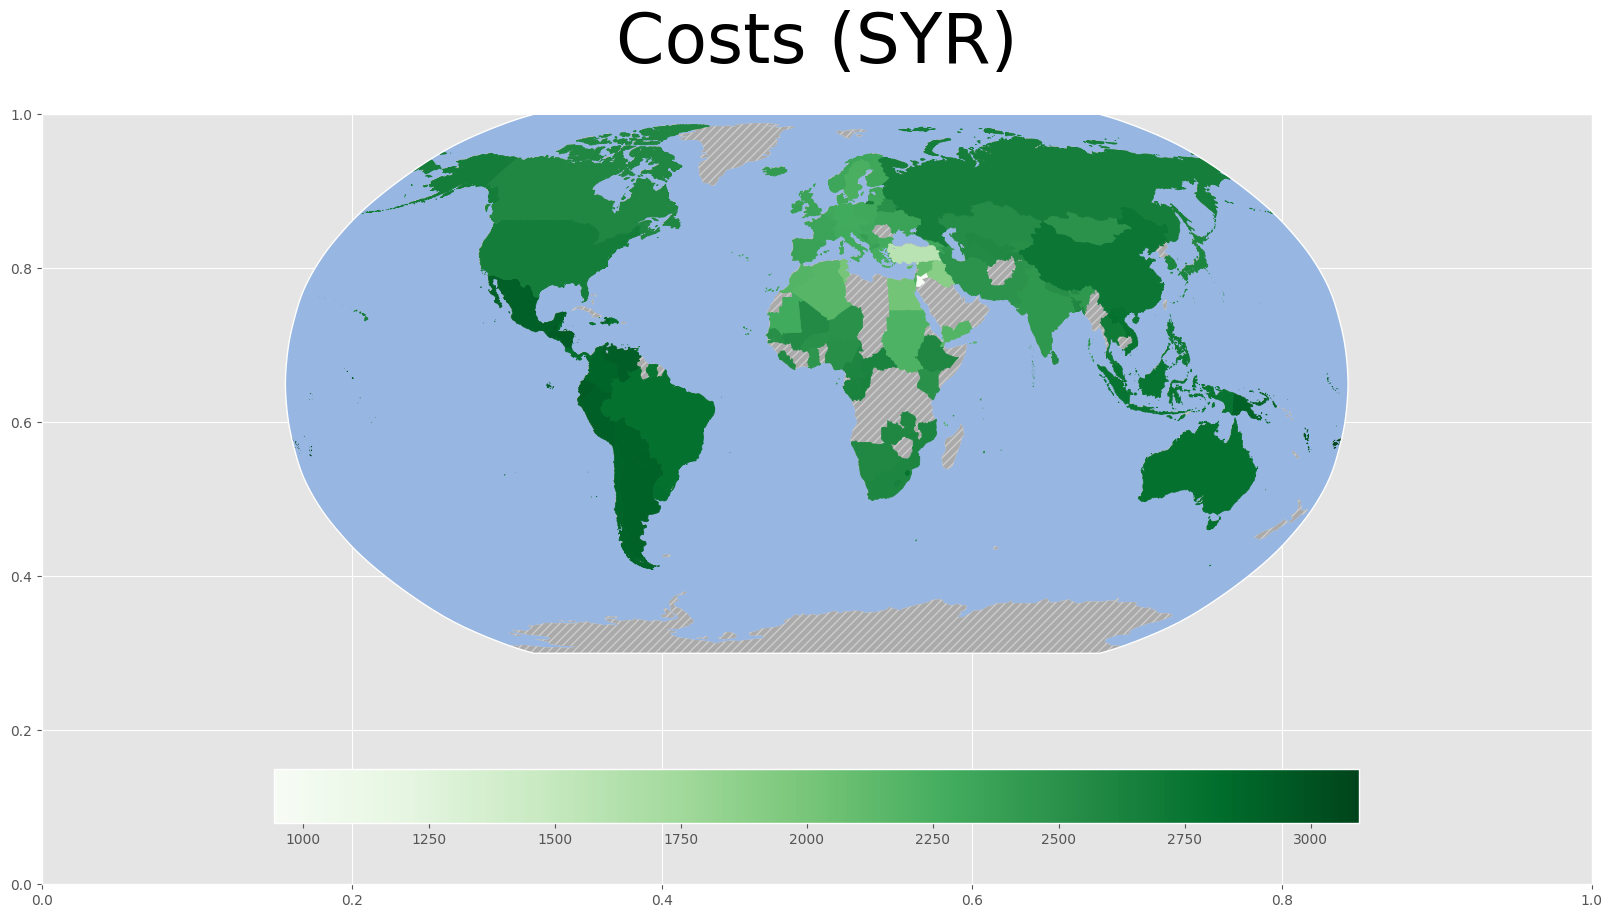

In [ ]:
map_plot(world.matrices["cost"]["SYR"], title="Costs (SYR)")

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

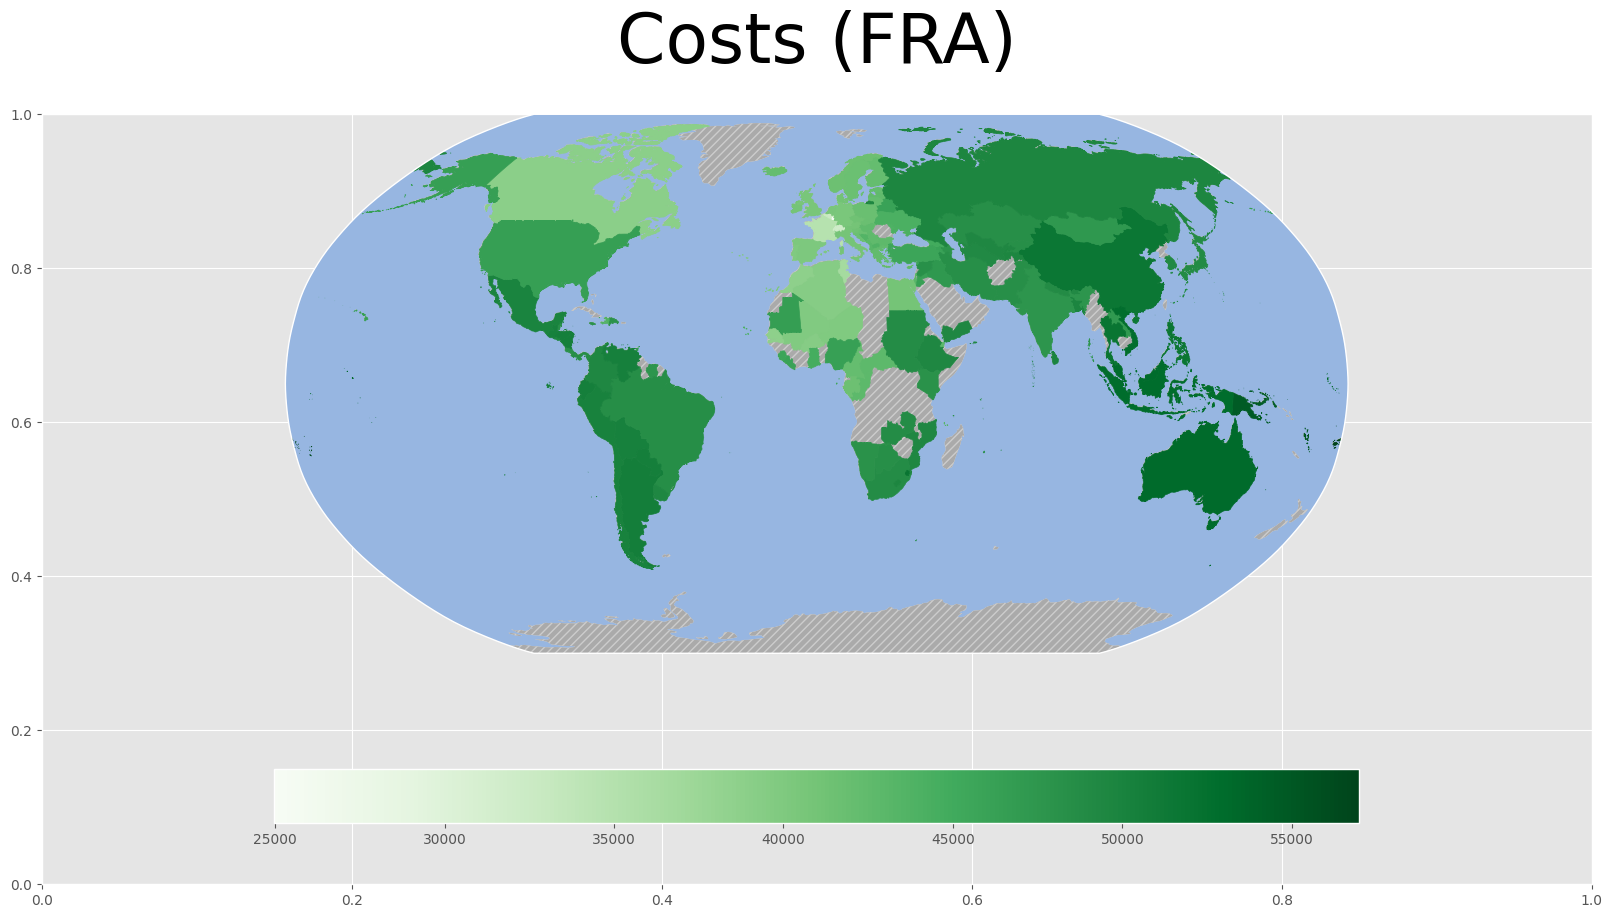

In [ ]:
map_plot(world.matrices["cost"]["FRA"], title="Costs (FRA)")

In [ ]:
world.update_neighborhoods((1 - world.data["Unemployment"]) * world.data["rts"], "wages")

Dropped:  []
Not found in other sets:  []


ALB      7185.776402
ARG     33515.053769
ARM      6536.322883
AUS    111678.046122
AUT     91329.606300
           ...      
VNM      5003.060067
VUT      6914.562131
YEM      1721.677049
ZAF     14740.333728
ZMB      3621.486147
Name: wages, Length: 134, dtype: float64

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

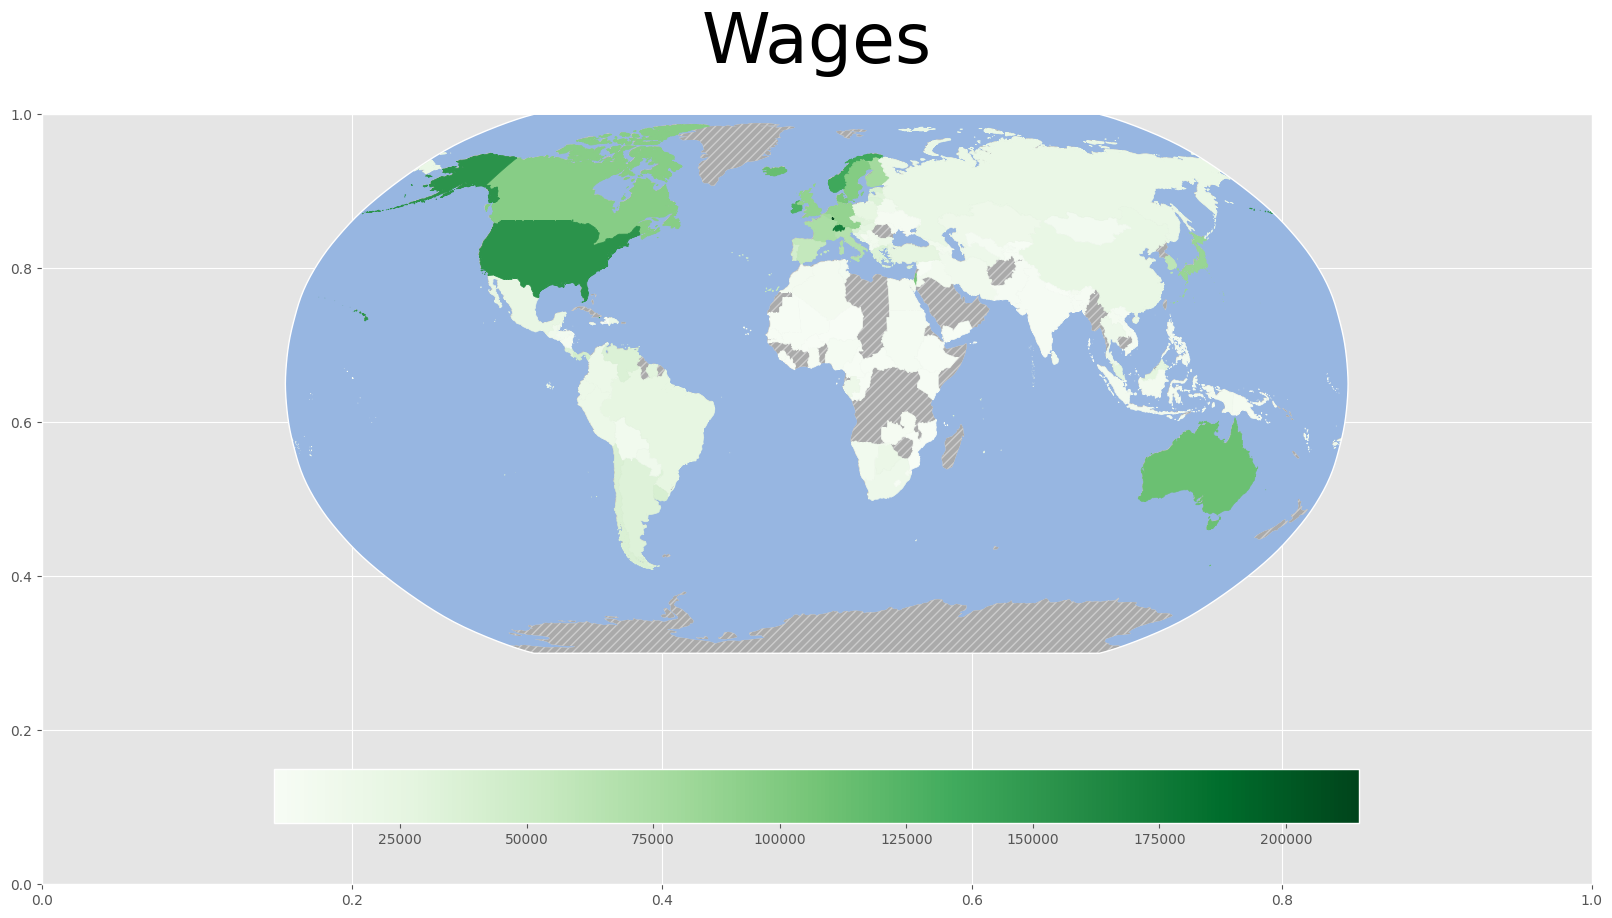

In [ ]:
map_plot(world.data["wages"], title="Wages")

In [ ]:
#beta = world.data.rts.mean()
#beta = RTS_list.median()

world.add_matrix("migration", (pd.DataFrame(
    np.array(
        [[x] * len(world.data) for x in world.data["wages"].values]
    ) - np.array(
        [list(world.data["wages"].values)] * len(world.data)
    ),
    world.data.index,
    world.data.index
    )  - world.matrices["cost"]).clip(lower=0))
world.matrices["migration"] = world.matrices["migration"] / (world.matrices["migration"].sum() + 1)
world.matrices["migration"] = world.matrices["migration"] / world.matrices["migration"].sum(axis=1).max()

# TODO: Why does this require being transposed?
world.matrices["migration"] = (0.15 * world.matrices["migration"].transpose() * world.data["Population"]).transpose()

world.matrices["migration"]

,ALB,ARG,ARM,AUS,AUT,AZE,BEL,BFA,BGD,BGR,...,UKR,URY,USA,UZB,VEN,VNM,VUT,YEM,ZAF,ZMB
ALB,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,32.425876,16.703903,0.000000,...,9.024908,0.000000,0.0,0.720112,0.000000,0.000000,0.000000,24.458417,0.000000,11.300226
ARG,2158.812718,0.000000,2219.236756,0.0,0.0,2139.369942,0.0,2440.054051,2417.097992,798.096324,...,2396.996491,0.000000,0.0,2365.632178,0.000000,2347.883487,2281.201047,2439.193022,1431.496525,2433.761305
ARM,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,28.361910,12.833888,0.000000,...,4.548797,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,20.498020,0.000000,6.959086
AUS,5479.164924,7567.734341,5404.816134,0.0,0.0,5528.782590,0.0,4450.699732,4817.497331,6462.810942,...,4954.265259,7697.182477,0.0,5097.612986,7248.058446,5193.837688,5501.694915,4653.174782,6386.402174,4918.831092
AUT,1677.756768,1890.234315,1651.945633,0.0,0.0,1683.680840,0.0,1380.743679,1479.145664,1926.205376,...,1527.239237,1713.648356,0.0,1563.596265,1884.702330,1575.874860,1649.886046,1437.802278,1848.717687,1511.451035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VNM,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,594.778332,160.255133,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,340.359695,0.000000,0.000000
VUT,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,2.418343,1.193236,0.000000,...,0.307677,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.761665,0.000000,0.664493
YEM,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,23.598942,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ZAF,311.746080,0.000000,466.976812,0.0,0.0,285.249610,0.0,1270.463694,1090.621213,0.000000,...,945.178109,0.000000,0.0,840.198784,0.000000,832.964615,449.127209,1173.970527,0.000000,1028.591277


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

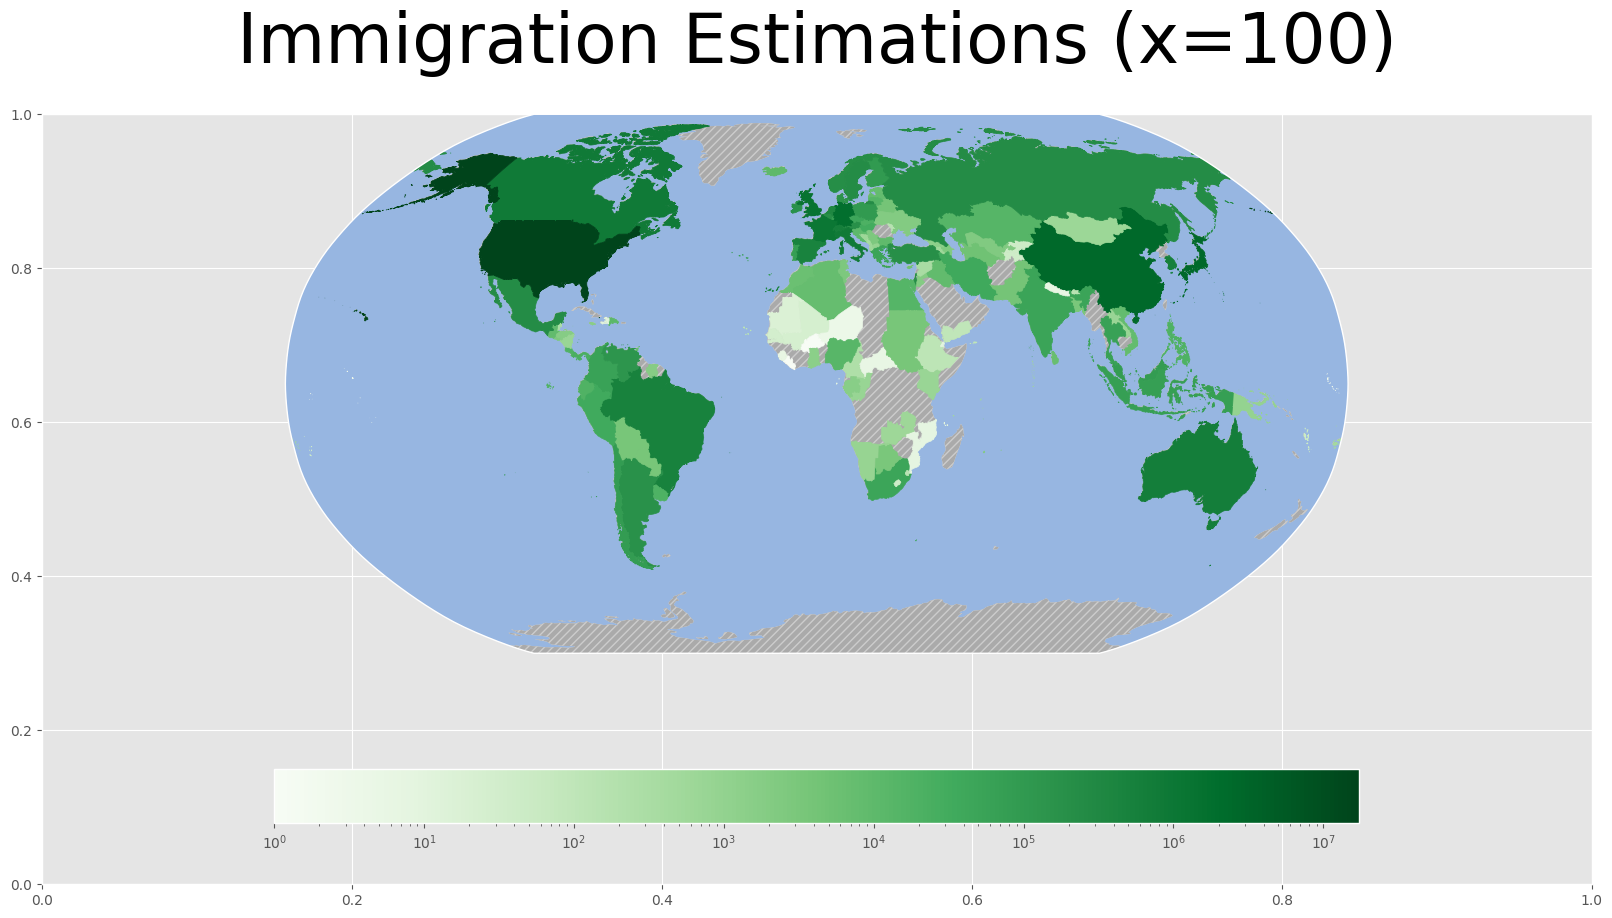

In [ ]:
map_plot(
   world.matrices["migration"].sum(axis=1)+1,
   title="Immigration Estimations (x={})".format(skill.value),
   normc=matplotlib.colors.LogNorm
)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

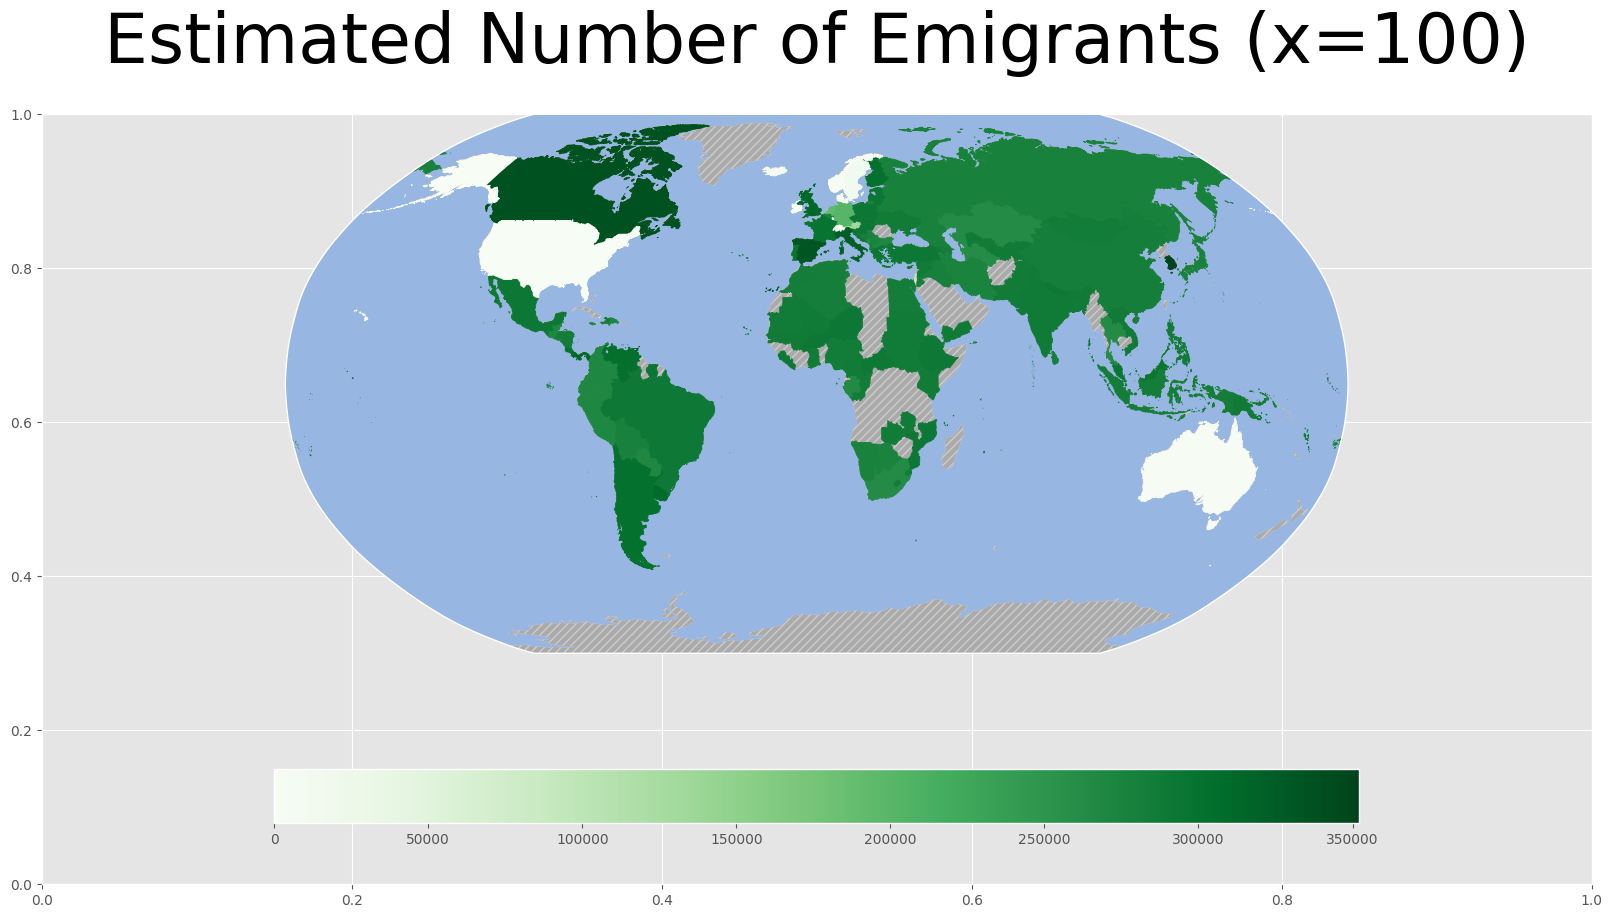

In [ ]:
map_plot(
   world.matrices["migration"].sum(),
   title="Estimated Number of Emigrants (x={})".format(skill.value),
   normc=matplotlib.colors.Normalize
)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

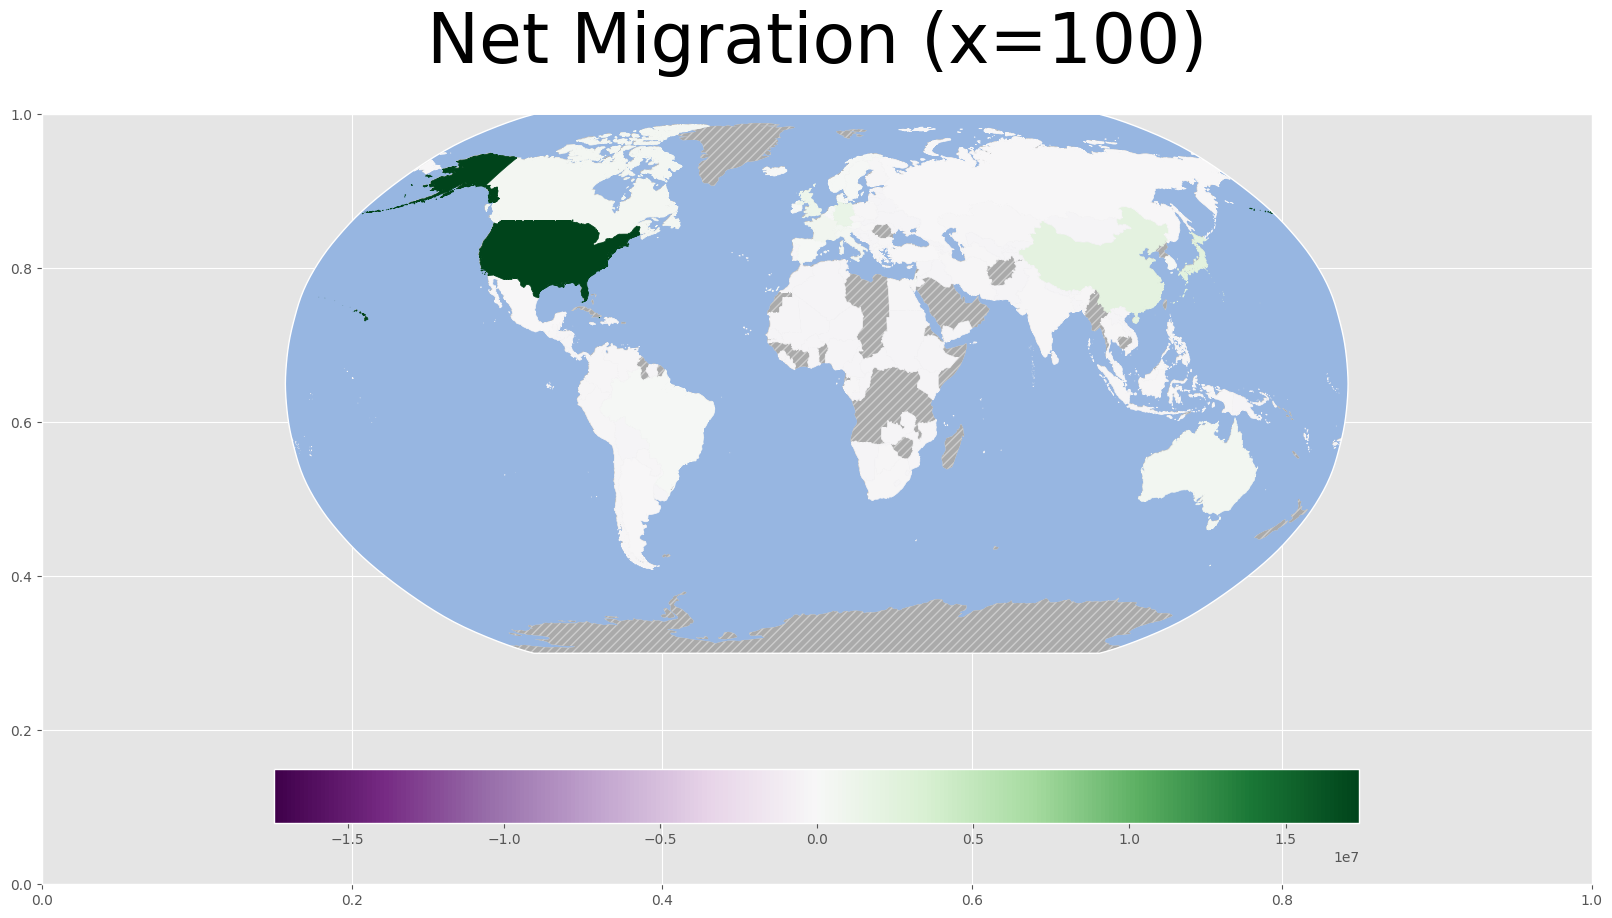

In [ ]:
map_plot(
   world.matrices["migration"].sum(axis=1) - world.matrices["migration"].sum(),
   title="Net Migration (x={})".format(skill.value),
   normc=gos.visualization.MidPointNorm
)

<font color=purple>

# Definición de vectores

</font>

In [ ]:
immigration = world.matrices["migration"].sum(axis=1)+1
emigration = world.matrices["migration"].sum()
net_migration = world.matrices["migration"].sum(axis=1) - world.matrices["migration"].sum()

<font color=purple>

# Comparando 2 países

</font>

Editar países

Cambie los valores de los códigos de país para simular mejor su escenario

In [ ]:
country_1 = "AUS"
country_2 = "ALB"

In [ ]:
one_to_two = int(world.matrices["migration"][country_1][country_2])

In [ ]:
two_to_one = int(world.matrices["migration"][country_2][country_1])

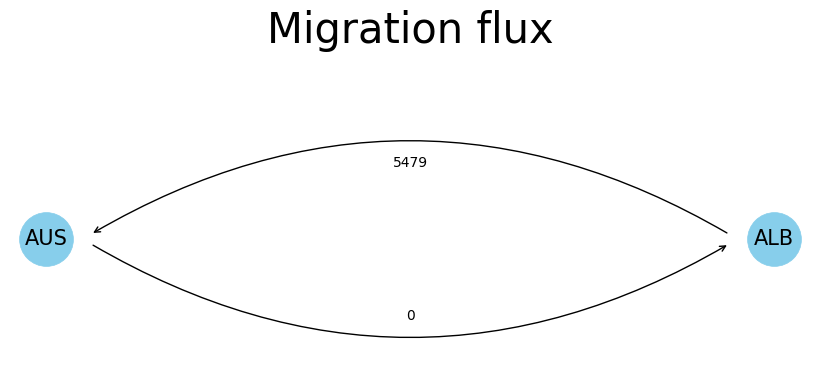

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt


G = nx.DiGraph()
G.add_nodes_from([country_1, country_2])


# graphing
pos = {country_1: (1, 0), country_2: (2, 0)}

plt.figure(figsize=(8,2.3))
nx.draw(G, pos, with_labels=True, node_size=1500, node_color="skyblue", font_size=15, arrows=True)

# plotting arrows
pos2 = {country_1: (1.05, 0), country_2: (1.95, 0)}
nx.draw_networkx_edges(G, pos2, edgelist=[(country_1, country_2)], width=1, arrows=True, connectionstyle='arc3, rad=0.3', arrowstyle='->')
nx.draw_networkx_edges(G, pos2, edgelist=[(country_2, country_1)], width=1, arrows=True, connectionstyle='arc3, rad=0.3', arrowstyle='->', label='Label 1')

# labels
plt.text(1.5, -0.6, one_to_two, ha='center', va='center')
plt.text(1.5, 0.6, two_to_one, ha='center', va='center')

# plotting
plt.title('Migration flux', pad=70, size=30)
# Adjust margins
plt.margins(y=0.8)
plt.show()

In [ ]:
immigration['USA']

17346069.266213987

<font color=purple>


# Exporting Data

</font>

<font color=purple>

Exportación de datos
- Para exportar los siguientes datos, elimine el "#" y ejecute la celda.
- Los archivos excel aparecerán en la carpeta de datos bajo GOS/examples/multiscale-migration/data.
- Cambie los nombres de los archivos (en rojo) cada vez que desee crear una hoja de cálculo con nuevos resultados. De lo contrario, los nuevos cambios anularán las hojas de cálculo originales.

</font>

In [ ]:
immigration.to_excel("data/baseline_immigration.xlsx")
emigration.to_excel("data/baseline_emigration.xlsx")
net_migration.to_excel("data/baseline_net_migration.xlsx")